<a href="https://colab.research.google.com/github/djmary-k/Py16DS_HW04/blob/main/Hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лінійна регресія: перенавчання і регуляризація

У цьому завданні ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

В усіх комірках, де вказаний коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Решту комірок із кодом (без коментарів) треба просто виконати. Крім того, у завданні необхідно відповідати на запитання; відповіді потрібно вписувати після виділеного слова "__Відповідь:__".

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Ми будемо працювати з датасетом __"bikes_rent.csv"__, у якому по днях записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів у цей день. Останнє ми будемо передбачати; таким чином, ми будемо розв'язувати завдання регресії.

### Ознайомлення з даними

## Завдання 1

Завантажте датасет за допомогою функції __pandas.read_csv__ у змінну __df__. Виведіть перші 5 рядків, щоб переконатися в коректному зчитуванні даних:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [179]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/bikes_rent.csv')
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для кожного дня прокату відомі такі ознаки:
* _season_: 1 — весна, 2 — літо, 3 — осінь, 4 — зима
* _yr_: 0 — 2011, 1 — 2012
* _mnth_: від 1 до 12
* _holiday_: 0 — немає свята, 1 — є свято
* _weekday_: від 0 до 6
* _workingday_: 0 — неробочий день, 1 — робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура в Цельсіях
* _atemp_: температура за відчуттями в Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях за годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова ознака, її ми будемо передбачати)

Отже, у нас є речові, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як з речовими. З номінальними ознаками теж можна працювати як з речовими, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від решти.

Побудуйте графіки залежностей атрибутів від кількості поїздок. Іншими словами, вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність чергового атрибута від змінної **cnt**.

In [4]:
df.shape

(731, 13)

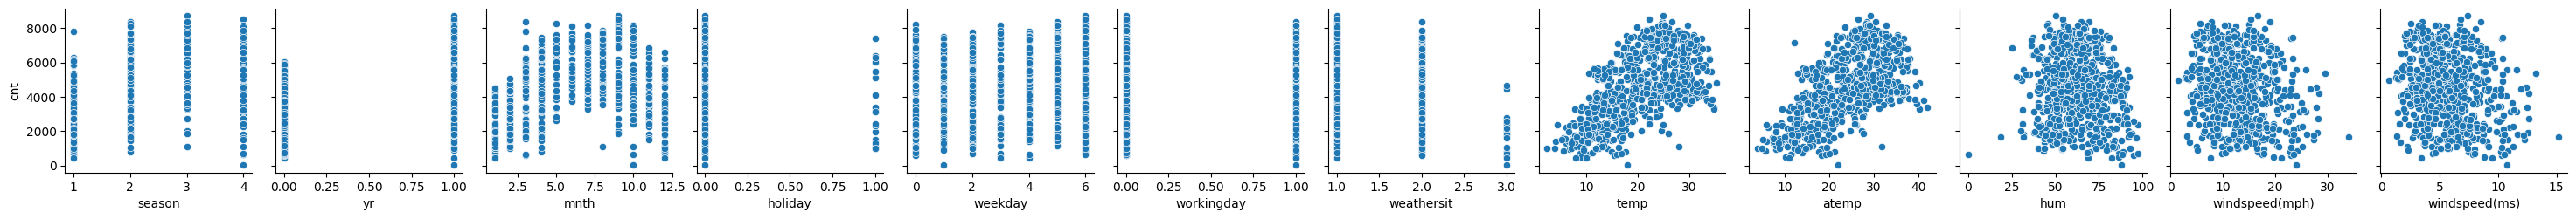

In [5]:
import seaborn as sns

sns.pairplot(df,
             x_vars= ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed(mph)',	'windspeed(ms)'],
             y_vars=['cnt'])
plt.show()

__Запитання:__
1. Яким є характер залежності кількості прокатів від місяця?
1. Вкажіть одну або дві ознаки, від яких кількість прокатів скоріше за все залежить лінійно.

***Відповідь:***
1. У весняні місяці кількість прокатів збільшується в порівняні з зимовими. Влітку прокат стабільньно високий, восени починає спадати, а взимку - найнижчий.
2. Можна зробити висновок, що скоріш за все кількість прокатів залежить лінійно від температури, вологості, швидкості вітру.

## Завдання 2

Давайте більш строго оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Гарною мірою лінійної залежності між двома векторами є кореляція Пірсона. Нам уже доводилося мати з нею справу раніше. Для її обчислення в pandas можна використовувати методи датафрейму: corr і corrwith.

Порахуйте кореляції всіх ознак, окрім останньої, з останньою за допомогою методу `corrwith`.

In [6]:
df.corrwith(df.loc[:]['cnt'], axis=0, method='pearson')

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
cnt               1.000000
dtype: float64

У вибірці є ознаки, що корелюють із цільовою, а отже, завдання можна розв'язувати лінійними методами.

За графіками видно, що деякі ознаки схожі між собою. Тому давайте також порахуємо кореляції між речовими ознаками.

## Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) і cnt
за допомогою методу corr:

In [7]:
df[['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']].corr()

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На діагоналях, як і належить, стоять одиниці. Однак у матриці є ще дві пари сильно корелюючих стовпців: temp і atemp (корелюють за своєю природою) і два windspeed (тому що це просто переведення одних одиниць в інші). Далі ми побачимо, що цей факт негативно позначається на навчанні лінійної моделі.

Насамкінець подивимося середні ознак (метод mean), щоб оцінити масштаб ознак і частки 1 у бінарних ознак.

## Завдання 4

Виведіть середні ознак.

In [8]:
df.mean()

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Ознаки мають різний масштаб, отже, для подальшої роботи нам краще нормувати матрицю об'єкти-ознаки.

### Проблема перша: колінеарні ознаки

Отже, у наших даних одна ознака дублює іншу, і є ще дві дуже схожі. Звичайно, ми могли б одразу видалити дублікати, але давайте подивимося, як відбувалося б навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо її середнє і поділимо на стандартне відхилення. Це можна зробити за допомогою методу scale.

Крім того, необхідно перемішати вибірку, це буде потрібно для крос-валідації.

In [9]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [10]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

In [11]:
X.shape

(731, 12)

In [12]:
y.shape

(731,)

Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [14]:
from sklearn.linear_model import LinearRegression

## Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі (ваги зберігаються у змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.


In [15]:
model = LinearRegression()
model.fit(X, y)
model.coef_

array([ 5.70863796e+02,  1.02196538e+03, -1.41301745e+02, -8.67593446e+01,
        1.37225064e+02,  5.63918818e+01, -3.30226462e+02,  3.67483733e+02,
        5.85549386e+02, -1.45614306e+02,  1.24571384e+13, -1.24571384e+13])

In [16]:
for feature, w in zip(df.columns, model.coef_):
  print(feature, w)

season 570.8637960129914
yr 1021.9653779400622
mnth -141.3017451148728
holiday -86.7593446245368
weekday 137.22506441350538
workingday 56.391881775973005
weathersit -330.2264620440312
temp 367.48373260182126
atemp 585.5493861188597
hum -145.61430569885857
windspeed(mph) 12457138390688.885
windspeed(ms) -12457138390887.346


Ми бачимо, що ваги при лінійно-залежних ознаках за модулем значно більші, ніж при інших ознаках. Щоб зрозуміти, чому так сталося, згадаємо аналітичну формулу, за якою обчислюються ваги лінійної моделі в методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо в $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Чим більш залежні ознаки, тим менший визначник цієї матриці й тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають _проблемою мультиколінеарності_.

З парою (temp, atemp) трохи менше корелюючих змінних такого не сталося, однак на практиці завжди варто уважно стежити за коефіцієнтами при схожих ознаках.

Для того щоб розв'язати проблему мультиколінеарності, потрібно скористатися регуляризатором. До оптимізуючого функціоналу додають $L_1$ або $L_2$ норму ваг, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а у другому — Ridge.

### Завдання 6
Давайте спробуємо навчити лінійні моделі з $L_1$ і $L_2$-регуляризацією, а далі порівняємо їхні ваги. Навчіть регресори Ridge і Lasso з параметрами за замовчуванням і переконайтеся, що проблема з вагами вирішилась.

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги.

In [17]:
from sklearn.linear_model import Lasso

lasso_regressor = Lasso()
lasso_regressor.fit(X, y)
lasso_regressor.coef_

array([ 5.60241616e+02,  1.01946349e+03, -1.28730627e+02, -8.61527813e+01,
        1.37347894e+02,  5.52123706e+01, -3.32369857e+02,  3.76363236e+02,
        5.76530794e+02, -1.44129155e+02, -1.97139689e+02, -2.80514042e-08])

In [18]:
for feature, w in zip(df.columns, lasso_regressor.coef_):
  print(feature, w)

season 560.2416160308861
yr 1019.4634940657196
mnth -128.73062703678696
holiday -86.15278133371106
weekday 137.34789390496314
workingday 55.21237064135668
weathersit -332.3698569623487
temp 376.3632362096943
atemp 576.530793504555
hum -144.12915500348583
windspeed(mph) -197.1396894024843
windspeed(ms) -2.8051404183533485e-08


In [ ]:
# Put your code here

season: 560.241616031
yr: 1019.46349407
mnth: -128.730627037
holiday: -86.1527813337
weekday: 137.347893905
workingday: 55.2123706414
weathersit: -332.369856962
temp: 376.36323621
atemp: 576.530793505
hum: -144.129155003
windspeed(mph): -197.139689402
windspeed(ms): -2.80498119457e-08


Навчіть лінійну модель з $L_2$-регуляризацією (клас Ridge) і виведіть ваги.

In [19]:
from sklearn.linear_model import Ridge

ridge_regression = Ridge().fit(X, y)
ridge_regression.coef_

array([ 563.06457225, 1018.94837879, -131.87332028,  -86.746098  ,
        138.00511118,   55.90311038, -332.3497885 ,  386.45788919,
        566.34704706, -145.0713273 ,  -99.25944108,  -99.25944115])

In [20]:
for feature, w in zip(df.columns, ridge_regression.coef_):
  print(feature, w)

season 563.0645722520181
yr 1018.9483787875305
mnth -131.87332028247715
holiday -86.74609799709232
weekday 138.00511117871918
workingday 55.90311037506467
weathersit -332.34978849907367
temp 386.45788919190807
atemp 566.3470470600669
hum -145.07132729867195
windspeed(mph) -99.25944108179067
windspeed(ms) -99.25944115434177


In [ ]:
# Put your code here

season: 563.064572252
yr: 1018.94837879
mnth: -131.873320282
holiday: -86.7460979971
weekday: 138.005111179
workingday: 55.9031103751
weathersit: -332.349788499
temp: 386.457889192
atemp: 566.34704706
hum: -145.071327299
windspeed(mph): -99.2594410818
windspeed(ms): -99.2594411544


### Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги при деяких ознаках. Давайте поспостерігаємо, як змінюються ваги зі збільшенням коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з `alphas` навчіть регресор `Lasso` і запишіть ваги у список `coefs_lasso`, а потім навчіть `Ridge` і запишіть ваги у список`coefs_ridge`. Конвертуйте отримані списки в `np.array`.

In [21]:
alphas = np.arange(1, 500, 50)

coefs_lasso = []
coefs_ridge = []

for alpha in alphas:
  reg_lasso_with_alpha = Lasso(alpha=alpha).fit(X, y)
  coefs_lasso.append(reg_lasso_with_alpha.coef_)
  reg_ridge_with_alpha = Ridge(alpha=alpha).fit(X, y)
  coefs_ridge.append(reg_ridge_with_alpha.coef_)

coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

print(f'coefs_lasso:\n {coefs_lasso}')
print(f'coefs_ridge:\n {coefs_ridge}')

coefs_lasso:
 [[ 5.60241616e+02  1.01946349e+03 -1.28730627e+02 -8.61527813e+01
   1.37347894e+02  5.52123706e+01 -3.32369857e+02  3.76363236e+02
   5.76530794e+02 -1.44129155e+02 -1.97139689e+02 -2.80514042e-08]
 [ 4.10969632e+02  9.77019409e+02 -0.00000000e+00 -5.34489688e+01
   9.19434374e+01  1.75372118e+01 -3.18125568e+02  3.22829934e+02
   6.10031512e+02 -9.10689615e+01 -1.45066095e+02 -2.29892889e-08]
 [ 3.70077089e+02  9.35945490e+02  0.00000000e+00 -1.21619360e+01
   4.88886342e+01  0.00000000e+00 -3.08805664e+02  2.69417263e+02
   6.32502623e+02 -2.75042876e+01 -9.37749037e+01 -2.41657943e-08]
 [ 3.32835717e+02  8.91870058e+02  0.00000000e+00 -0.00000000e+00
   0.00000000e+00  0.00000000e+00 -2.79616688e+02  2.11052030e+02
   6.62920880e+02 -0.00000000e+00 -5.01551472e+01 -2.62789872e-08]
 [ 2.98134448e+02  8.45652857e+02  0.00000000e+00 -0.00000000e+00
   0.00000000e+00  0.00000000e+00 -2.35571345e+02  1.24144807e+02
   7.25379483e+02 -0.00000000e+00 -1.26461769e+01 -2.78775

Проаналізуйте динаміку ваг при збільшенні параметра регуляризації:

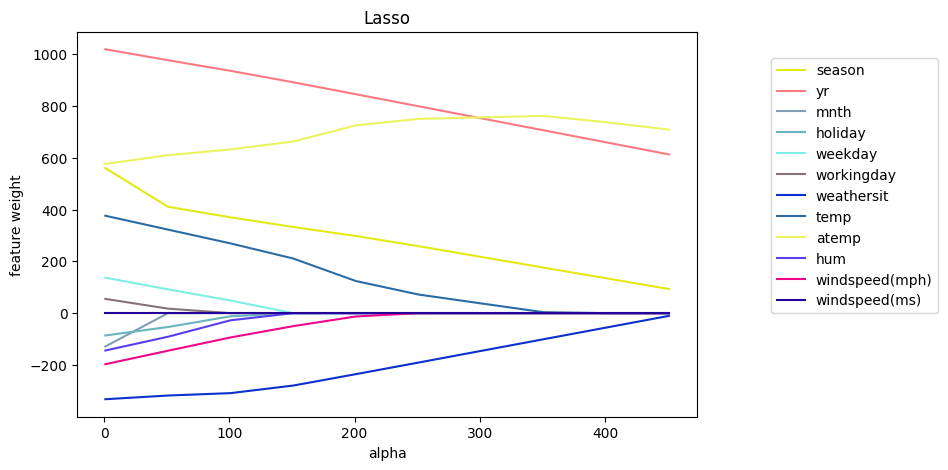

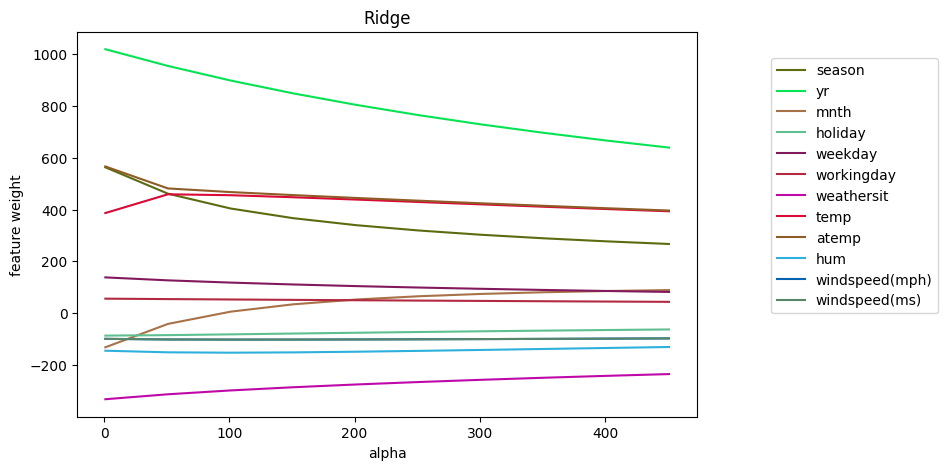

In [22]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при одному й тому самому alpha?
1. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть, чому так відбувається.
1. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` при будь-якому значенні `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт при ньому менший $10^{-3}$.
1. Який із регуляризаторів підійде для відбору неінформативних ознак?

***Відповідь:***
1. На мою думку регуляризатор Ridge справився з задачею краще.
2. Якщо альфа зробити дуже великим, то деякі ваги Lasso виявляться рівними нулю, що призведе до виключення певних ознак.
Мені здається що це якось звязано з недонавчання чи перенавчанням.
3. Так, дивлячись на графік можна стверджувати, що ознака windspeed була виключенна Lasso. А от регуляризатор Ridge не виключив жодну з ознак.
4. Lasso.


### Завдання 8

Далі будемо працювати з `Lasso`.

Отже, ми бачимо, що при зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику сам оптимізований функціонал методу найменших квадратів, тобто `Mean Square Error`.

По-друге, потрібно зрозуміти, на яких даних цю метрику рахувати. Не можна вибирати `alpha` за значенням MSE на навчальній вибірці, тому що тоді ми не зможемо оцінити, як модель буде робити передбачення на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну та тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити декілька розбиттів вибірки, на кожному пробувати різні значення alpha, а потім усереднювати MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ частин, і кожного разу брати одну з них як тестову, а з блоків, що залишилися, складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn зовсім просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список із alpha і для кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор буде містити змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (число блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків. Крім того, у змінній alpha\_ буде зберігатися вибране значення параметра регуляризації, а в coef\_, традиційно, навчені ваги, що відповідають цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, у якому він проходить по alphas; для зіставлення з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ за рядками `MSE` в залежності від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

In [173]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

In [ ]:
regressor = LassoCV(alphas=alphas, cv=3).fit(X, y)
regressor.mse_path_

In [ ]:
regressor.alphas_

In [ ]:
regressor.coef_

In [180]:
print(f'Вибране alpha: {regressor.alpha_}')

Вибране alpha: 6


In [181]:
for feature, w in zip(df.columns, regressor.coef_):
  print(feature, w)

season 532.0189828413535
yr 1015.0602226430595
mnth -100.03952614356629
holiday -83.29395987529904
weekday 132.50446549095795
workingday 51.557085614073735
weathersit -330.5598567399817
temp 370.67985503003405
atemp 581.396931065498
hum -140.00740550068844
windspeed(mph) -191.77140847135036
windspeed(ms) -2.6854702314758792e-08


Побудуйте графік усередненого за рядками MSE в залежності від alpha (використовуйте для цього функцію create_plot).

In [182]:
data_y = regressor.mse_path_.mean(axis=1)
data_x = regressor.alphas_

In [183]:
def create_plot(x, y, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    # x = map(lambda e: e[0], data)
    # y = map(lambda e: e[1], data)
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

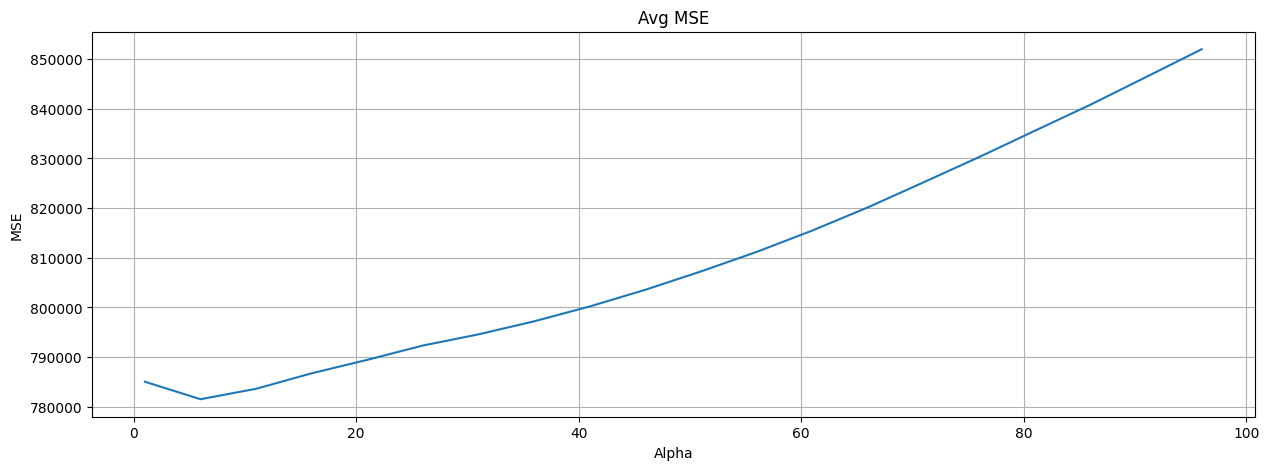

In [184]:
create_plot(data_x, data_y, 'Avg MSE', 'Alpha', 'MSE')

In [ ]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = map(lambda e: e[0], data)
    y = map(lambda e: e[1], data)
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

Alpha = 6

season: 532.018982841
yr: 1015.06022264
mnth: -100.039526144
holiday: -83.2939598753
weekday: 132.504465491
workingday: 51.5570856141
weathersit: -330.55985674
temp: 370.67985503
atemp: 581.396931065
hum: -140.007405501
windspeed(mph): -191.771408471
windspeed(ms): -2.68545418157e-08


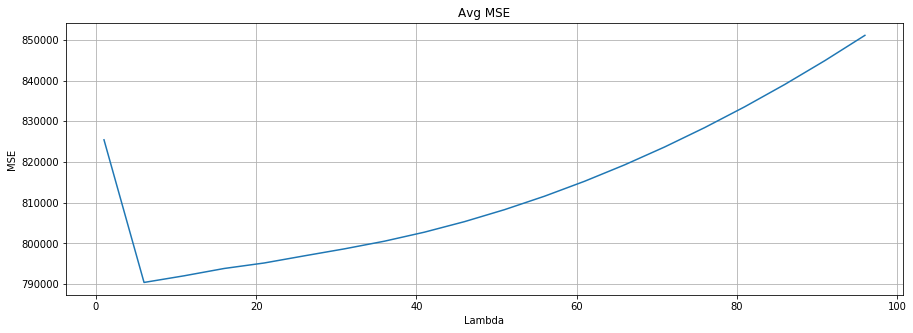

In [ ]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

regressor = # Put your code here

Отже, ми вибрали певний параметр регуляризації. Давайте подивимося, які б ми вибирали alpha, якби ділили вибірку лише один раз на навчальну та тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

### Завдання 9

Виведіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбитті (тобто за стовпцями).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.


In [133]:
regressor.mse_path_

array([[830768.68693702, 919721.93589263, 805481.54522903],
       [822965.9041311 , 911867.54470864, 804343.02766964],
       [815129.08593972, 903855.55058088, 803483.74706927],
       [807667.98224742, 896148.95236924, 802906.09265381],
       [800137.23263318, 888747.72399201, 801974.9311743 ],
       [793005.6616591 , 881651.8631318 , 800937.92121214],
       [786275.36724172, 874861.36810104, 799342.37031522],
       [779946.35004807, 868376.23749144, 798151.12777192],
       [774018.6100807 , 862196.47012638, 797363.63293845],
       [768492.14733962, 856322.06502308, 796979.89551936],
       [763366.96182482, 850359.8722302 , 796999.92588656],
       [758643.05353631, 844566.95589129, 797423.73295863],
       [754320.42247408, 839080.96310802, 798251.32439694],
       [750399.06863813, 833901.906581  , 799482.70678255],
       [746878.99046623, 829029.79332371, 801117.80350671],
       [742255.05212855, 824464.62917087, 801674.30830821],
       [738465.37393446, 819052.82694159

In [162]:
mse_data = pd.DataFrame(regressor.mse_path_)
alpha_data =pd.Series(regressor.alphas_)
# print(mse_data.min())
# print(mse_data.idxmin())
print('Alphas with minimum MSE:')
for i in range(len(mse_data.min())):
  print(f'Alpha = {alpha_data[mse_data.idxmin()[i]]}, MSE = {mse_data.min()[i]}')

Alphas with minimum MSE:
Alpha = 6, MSE = 733725.7604052249
Alpha = 1, MSE = 799433.1673691692
Alpha = 51, MSE = 796979.8955193626


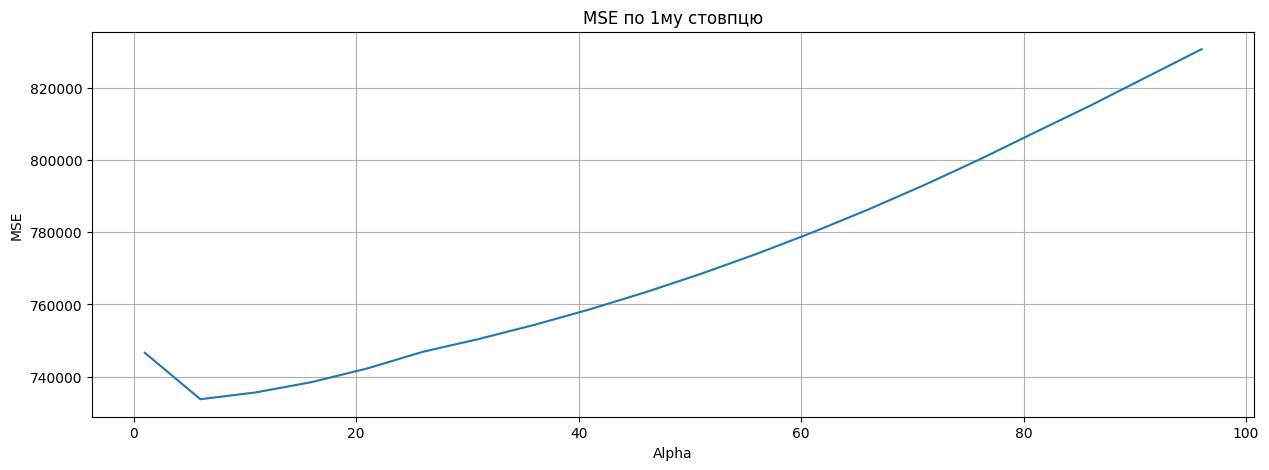

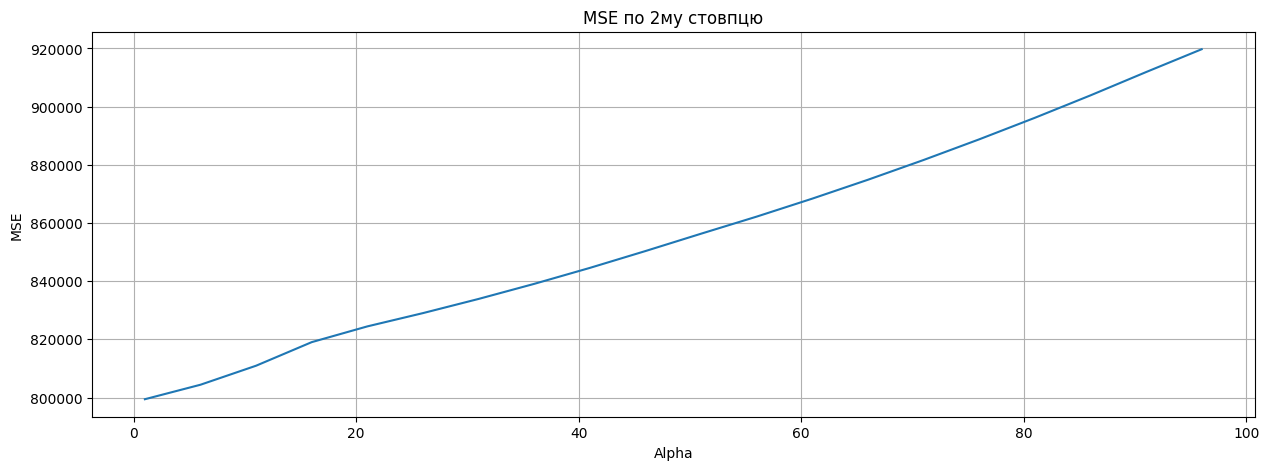

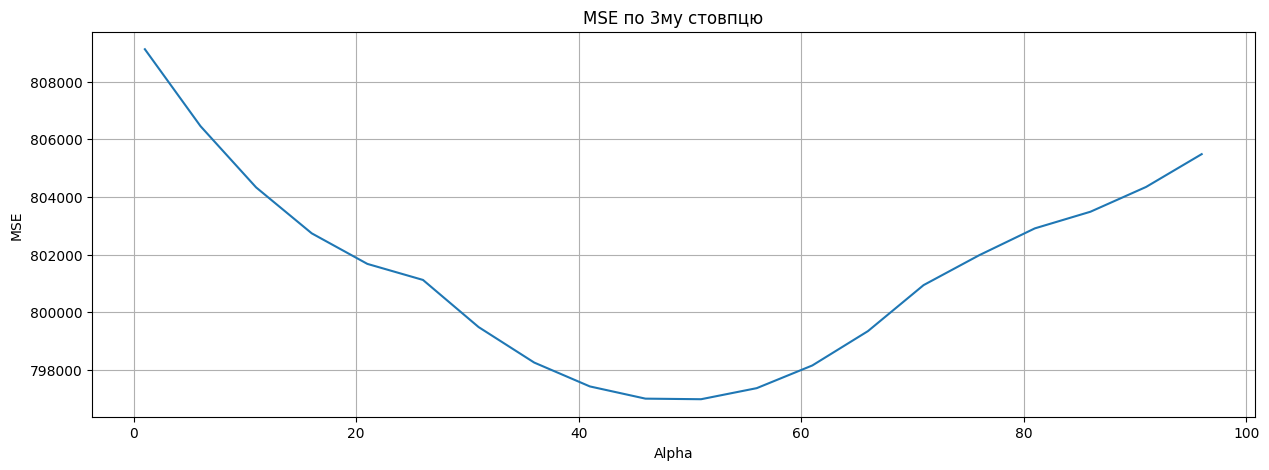

In [172]:
create_plot(data_x, mse_data[0], 'MSE по 1му стовпцю', 'Alpha', 'MSE')
create_plot(data_x, mse_data[1], 'MSE по 2му стовпцю', 'Alpha', 'MSE')
create_plot(data_x, mse_data[2], 'MSE по 3му стовпцю', 'Alpha', 'MSE')

In [ ]:
# Put your code here

Alphas with minimum MSE:
Alpha = 41, MSE = 843336.181499
Alpha = 6, MSE = 772598.495628
Alpha = 1, MSE = 745668.605961


На кожному розбитті оптимальне значення `alpha` своє, і йому відповідає велике MSE на інших розбиттях. Виходить, що ми налаштовуємося на конкретні навчальні та контрольні вибірки. При виборі `alpha` на крос-валідації ми вибираємо дещо "середнє", що даватиме прийнятне значення метрики на різних розбиттях вибірки.

### Завдання 10

Нарешті, як прийнято в аналізі даних, давайте проінтерпретуємо результат. Дайте відповіді на наступні запитання.

#### Запитання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей `cnt` від цих ознак, які ми зображали у блоці "Ознайомлення з даними". Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками? Чи логічно стверджувати (виходячи зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

__Відповідь:__

In [203]:
data_feature_w = pd.DataFrame([df.columns[:-1], regressor.coef_], index=['feature', 'w']).T
data_feature_w.sort_values(['w'], ascending=False).head(4)

,feature,w
1,yr,1015.060223
8,atemp,581.396931
0,season,532.018983
7,temp,370.679855


In [ ]:
# За даними графіками не видно зростаючу лінійну залежність cnt від цих ознак.
# Ні, не логічно стверджувати що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди.

#### Запитання 2

Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами (і випишіть їх), подивіться на відповідні візуалізації. Чи видно лінійну залежність, що зменшується? Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?

__Відповідь:__

In [205]:
data_feature_w.sort_values(['w'], ascending=True).head(3)

,feature,w
6,weathersit,-330.559857
10,windspeed(mph),-191.771408
9,hum,-140.007406


In [ ]:
# На даних графіках ми можемо спостерігати лінійну залежність що зменшується.
# У відповідності до цих ознак логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди.

#### Запитання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (< 1e-3). Як ви думаєте, чому модель виключила їх із моделі (знову подивіться на графіки)? Чи правда, що вони ніяк не впливають на попит на велосипеди?

__Відповідь:__

In [ ]:
# windspeed(ms) -2.6854702314758792e-08

In [ ]:
# Близькою до нуля є ознака windspeed(ms) -2.6854702314758792e-08.
# Насправді,  я не докінця розумію чому модель виключила цю ознаку, але дивлячись на графік я бачу що ця фіча дублюється.
# На рахунок попипиту, я не згідна що ця не впливає.

### Висновок
Отже, ми подивилися, як можна стежити за адекватністю лінійної моделі, як відбирати ознаки і як грамотно, за можливості не налаштовуючись на якусь конкретну порцію даних, підбирати коефіцієнт регуляризації.

Варто зазначити, що за допомогою крос-валідації зручно підбирати лише невелику кількість параметрів. (1, 2, максимум 3), тому що для кожної допустимої їх комбінації нам доводиться декілька разів навчати модель. Такий процес займає багато часу, особливо якщо треба навчатися на великих обсягах даних.